In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(url="https://github.com/kleinhenz/Keldysh.jl", rev="matrix_valued")
Pkg.add(["PyPlot"])
# Pkg.update()
Pkg.status()

  Activating environment at `~/dev/QInchworm.jl/experiments/anderson/Project.toml`
    Updating git-repo `https://github.com/kleinhenz/Keldysh.jl`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/dev/QInchworm.jl/experiments/anderson/Project.toml`
  No Changes to `~/dev/QInchworm.jl/experiments/anderson/Manifest.toml`
   Resolving package versions...
  No Changes to `~/dev/QInchworm.jl/experiments/anderson/Project.toml`
  No Changes to `~/dev/QInchworm.jl/experiments/anderson/Manifest.toml`


      Status `~/dev/QInchworm.jl/experiments/anderson/Project.toml`
  [50f2bc7e] Keldysh v0.6.0 `https://github.com/kleinhenz/Keldysh.jl#matrix_valued`
  [d330b81b] PyPlot v2.9.0


In [101]:
using LinearAlgebra, Printf
using PyPlot; 
pygui(false); PyPlot.svg(true);
using Keldysh

In [3]:
#@enum SpinEnum spin_up = UInt8(1) spin_down=UInt8(2)
@enum SpinEnum spin_up = UInt8(1)

Base.to_index(A, sp::SpinEnum) = Int(sp)
#flip(sp::SpinEnum) = sp == spin_up ? spin_down : spin_up

# type representing state of anderson impurity
# occupation of up/down stored in first two bits
struct FockState
    state::UInt8
    function FockState(s)
        #@assert s < 4
        @assert s < 2
        new(s)
    end
end

# check whether ith spin is occupied
# note sp ∈ [1, 2] so don't need to do (1 << (sp - 1))
Base.getindex(st::FockState, sp::SpinEnum) = (st.state & UInt8(sp)) > 0

# flip occupation of ith spin
# note sp ∈ [1, 2] so don't need to do (sp << (i - 1))
flip(st::FockState, sp::SpinEnum) = FockState(st.state ⊻ UInt8(sp))

# convert internal state to index
Base.to_index(st::FockState) = Int(st.state + 1)

In [4]:
struct NCAParams
  dyson_rtol::Float64
  dyson_atol::Float64
  dyson_max_iter::Int
  max_order::Int
  function NCAParams(dyson_rtol, dyson_atol, dyson_max_iter, max_order)
    @assert 1 <= max_order <= 2
    new(dyson_rtol, dyson_atol, dyson_max_iter, max_order)
  end
end
NCAParams(; dyson_rtol = 1e-6, dyson_atol = 1e-10, dyson_max_iter = 100, max_order = 1) = NCAParams(dyson_rtol, dyson_atol, dyson_max_iter, max_order)

struct NCAData{T <: AbstractTimeGF, U <: AbstractTimeGrid}
  P0::Array{T,1} # bare propagator
  Δ::Array{T, 1} # hybridization function

  P::Array{T,1} # dressed propagator
  Σ::Array{T,1} # self-energy
  ΣxP::Array{T,1} # self-energy convolved with propagator
  G::Array{T,1} # green's function

  grid::U # time grid
  #states::NTuple{4, FockState}
  states::NTuple{2, FockState}
  #spins::Tuple{SpinEnum, SpinEnum}
  spins::Tuple{SpinEnum}
  #spins::NTuple{1, SpinEnum}
end

function NCAData(P0, Δ)
  #states = ntuple(i -> FockState(i-1), 4)
  states = ntuple(i -> FockState(i-1), 2) # single fermionic state
  spins = instances(SpinEnum)

  statesize = length(states)
  indexsize = length(spins)

  @assert length(P0) == statesize
  @assert length(Δ) == indexsize

  grid = first(P0).grid

  X = P0[1]
  P = [zero(X) for _ in 1:statesize]
  Σ = [zero(X) for _ in 1:statesize]
  ΣxP = [zero(X) for _ in 1:statesize]
  G = [zero(X) for _ in 1:indexsize]

  NCAData(P0, Δ, P, Σ, ΣxP, G, grid, states, spins)
end

NCAData

In [5]:
function Σnca(data::NCAData, t1::TimeGridPoint, t2::TimeGridPoint, st_sigma::FockState)
  sum(data.spins) do sp
    st_prop = flip(st_sigma, sp)
    1.0im * data.P[st_prop][t1, t2] * (st_sigma[sp] ? data.Δ[sp][t1, t2] : -data.Δ[sp][t2, t1, false])
  end
end

Σnca (generic function with 1 method)

In [6]:
function dyson!(data::NCAData, t1::TimeGridPoint, t2::TimeGridPoint, params::NCAParams)
  @assert t1.idx >= t2.idx

  p_t1t2_cur = zeros(ComplexF64, length(data.states))
  p_t1t2_next = zeros(ComplexF64, length(data.states))

  for st in data.states
    p_t1t2_cur[st] = data.P0[st][t1,t2]
    data.P[st][t1,t2] = data.P0[st][t1,t2] # initial guess
  end

  ↻ = (A, B) -> integrate(t -> @inbounds(A[t1, t] * B[t, t2]), data.grid, t1, t2)

  done = false
  iter = 1
  diff = 0.0
  while iter <= params.dyson_max_iter && !done

    for st in data.states
      p_t1t2_next[st] = 0.0

      data.Σ[st][t1, t2] = 0.0
      params.max_order > 0 && (data.Σ[st][t1, t2] += Σnca(data, t1, t2, st))
      params.max_order > 1 && (data.Σ[st][t1, t2] += Σoca(data, t1, t2, st))

      # p = p₀ + p₀ ↻ Σ ↻ p
      data.ΣxP[st][t1, t2] = data.Σ[st] ↻ data.P[st]
      p_t1t2_next[st] += data.P0[st] ↻ data.ΣxP[st]

      p_t1t2_next[st] += data.P0[st][t1, t2]
    end

    diff = norm(p_t1t2_cur - p_t1t2_next)
    done = diff < max(params.dyson_atol, params.dyson_rtol * norm(p_t1t2_cur))
    for st in data.states
      data.P[st][t1,t2] = p_t1t2_next[st]
    end
    p_t1t2_cur .= p_t1t2_next
    iter += 1
  end
end

function nca!(data::NCAData, params::NCAParams)
  N = length(data.grid)
  for d in 0:(N-1) # solve diagonal by diagonal
#     println("diagonal $(d+1)/$N")
    for j in 1:(N-d)
      i = j + d
      t1 = data.grid[i]
      t2 = data.grid[j]
      dyson!(data, t1, t2, params)
    end
  end

  return data
end

nca! (generic function with 1 method)

In [14]:
struct SplitPropagator
  P::GenericTimeGF{ComplexF64,true}
  P0::GenericTimeGF{ComplexF64,true}
  t_split::TimeGridPoint
end

function Base.getindex(P::SplitPropagator, t1::TimeGridPoint, t2::TimeGridPoint)
  @assert t1.idx >= t2.idx
  t_split = P.t_split
  
  if t1.idx <= t_split.idx
    return P.P[t1, t2]
  elseif t1.idx > t_split.idx && t2.idx < t_split.idx
    return im * P.P0[t1, t_split] * P.P[t_split, t2]
  elseif t2.idx >= t_split.idx
    return P.P0[t1, t2]
  else
    error("unreachable")
  end
end

struct InchParams
  max_order::Int
end
InchParams(; max_order = 1) = InchParams(max_order)

struct InchData{T <: AbstractTimeGF, U <: AbstractTimeGrid}
  P0::Array{T,1} # bare propagator
  P::Array{T,1} # dressed propagator
  Δ::Array{T, 1} # hybridization function
  G::Array{T,1} # green's function

  grid::U # time grid
  #states::NTuple{4, FockState}
  states::NTuple{2, FockState}
  #spins::Tuple{SpinEnum, SpinEnum}
  spins::Tuple{SpinEnum}
end


function InchData(P0, Δ)
  #states = ntuple(i -> FockState(i-1), 4)
  states = ntuple(i -> FockState(i-1), 2)
  spins = instances(SpinEnum)

  statesize = length(states)
  indexsize = length(spins)

  @assert length(P0) == statesize
  @assert length(Δ) == indexsize

  grid = first(P0).grid

  X = P0[1]
  P = [zero(X) for _ in 1:statesize]
  G = [zero(X) for _ in 1:indexsize]

  InchData(P0, P, Δ, G, grid, states, spins)
end

function inch_order0(data::InchData, t1::TimeGridPoint, t2::TimeGridPoint, st::FockState)
  @assert t1.idx >= t2.idx
  
  if t1.idx == t2.idx
    return data.P0[st][t1, t2]
  end
  
  P0, P, Δ, grid = data.P0, data.P, data.Δ, data.grid
  
  t_split = grid[t1.idx - 1]
  P_split = [SplitPropagator(P[s], P0[s], t_split) for s in 1:length(P)]
  return P_split[st][t1, t2]
end

function inch_order1(data::InchData, t1::TimeGridPoint, t4::TimeGridPoint, st::FockState)
  @assert t1.idx >= t4.idx
  
  if t1.idx == t4.idx
    return 0.0im
  end
  
  P0, P, Δ, grid = data.P0, data.P, data.Δ, data.grid
  
  grid = P[1].grid
  
  t_split = grid[t1.idx - 1]
  P_split = [SplitPropagator(P[s], P0[s], t_split) for s in 1:length(P)]
  
  sum(data.spins) do sp
    s0 = st
    s1 = flip(st, sp)
    s2 = st
    
    hyb = (t2, t3) -> st[sp] ? Δ[sp][t2, t3] : -Δ[sp][t3, t2, false]
    loc = (t2, t3) -> im * P_split[s2][t1, t2] * P_split[s1][t2, t3] * P_split[s0][t3, t4]
    
    f = t2 -> integrate(t3 -> hyb(t2, t3) * loc(t2, t3), grid, t2, t4)
    return integrate(f, grid, t1, t_split)
  end
end

function inch!(data::InchData, t1::TimeGridPoint, t2::TimeGridPoint, params::InchParams)
  for st in data.states
    x = inch_order0(data, t1, t2, st)
    params.max_order > 0 && (x += inch_order1(data, t1, t2, st))
    data.P[st][t1,t2] = x
  end
end


function inch!(data::InchData, params::InchParams)
  N = length(data.grid)
  for d in 0:(N-1) # solve diagonal by diagonal
    for j in 1:(N-d)
      i = j + d
      t1 = data.grid[i]
      t2 = data.grid[j]
      inch!(data, t1, t2, params)
    end
  end

  return data
end

inch! (generic function with 2 methods)

In [8]:
function make_bare_prop(grid::KeldyshTimeGrid, ρ, ϵ, U)
  #E = [0.0, ϵ, ϵ, 2*ϵ + U]
  #ξ = [1.0, -1.0, -1.0, 1.0]
  E = [0.0, ϵ]
  ξ = [1.0, -1.0]
  #P = map(1:4) do s
  P = map(1:2) do s
    GenericTimeGF(grid, 1, true) do t1, t2
      t1.idx < t2.idx && return 0.0
      ϕ = integrate(t -> E[s], grid, t1, t2)
      heaviside(t1.val, t2.val) ? -im * exp(-im * ϕ) : -im * ξ[s] * ρ[s] * exp(-im * ϕ)
    end
  end
  return P
end

function make_bare_prop(grid::FullTimeGrid, ϵ, U)
  #E = [0.0, ϵ, ϵ, 2*ϵ + U]
  #ξ = [1.0, -1.0, -1.0, 1.0]
  E = [0.0, ϵ]
  ξ = [1.0, -1.0]
  #P = map(1:4) do s
  P = map(1:2) do s
    GenericTimeGF(grid, 1, true) do t1, t2
      t1.idx < t2.idx && return 0.0
      ϕ = integrate(t -> E[s], grid, t1, t2)
      heaviside(t1.val, t2.val) ? -im * exp(-im * ϕ) : -im * ξ[s] * exp(-im * ϕ)
    end
  end
  return P
end

make_bare_prop (generic function with 2 methods)

In [9]:
"""
Compute the populations (i.e. the diagonal components of the impurity density matrix) from a propagator
"""
function populations(P)
  nstates = length(P)
  #ξ = [1.0, -1.0, -1.0, 1.0]
  ξ = [1.0, -1.0]
  P_lsr_diag = reduce(hcat, (1.0im * ξ[s] * diag(P[s][:lesser]) for s in 1:nstates))
  Zt = sum(P_lsr_diag, dims=2)
  ρt = P_lsr_diag ./ Zt
  return ρt, Zt
end

populations

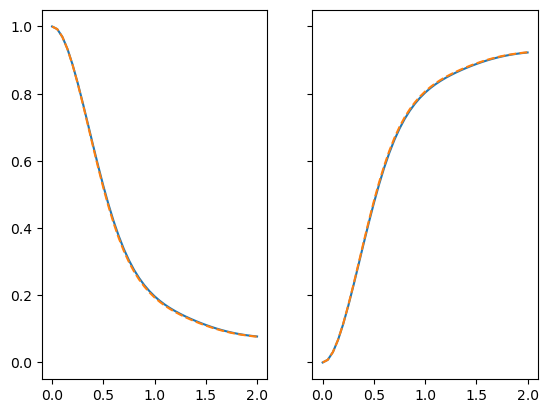

In [15]:
function run_inch_keldysh()
  tmax = 2.0
  β = 2.0
  nt = 41
  
  c = twist(KeldyshContour(; tmax))
  grid = KeldyshTimeGrid(c, nt)
  
  #ρ = [1.0, 0.0, 0.0, 0.0]
  ρ = [1.0, 0.0]
  ϵ = -4.0
  U = 8.0
  P0 = make_bare_prop(grid, ρ, ϵ, U)
  
  dos = flat_dos(;D=10.0, ν=10.0)
  #Δ = [GenericTimeGF(dos, β, grid) for s in 1:2]
  Δ = [GenericTimeGF(dos, β, grid)]
  
  nca_params = NCAParams(max_order = 1)
  nca_data = NCAData(P0, Δ)
  nca!(nca_data, nca_params)
  
  inch_params = InchParams(max_order = 1)
  inch_data = InchData(P0, Δ)
  inch!(inch_data, inch_params)
  
  t = collect(realtimes(grid))
  
  ρt_nca, Zt_nca = populations(nca_data.P)
  ρt_inch, Zt_inch = populations(inch_data.P)
  
  fig, axes = plt.subplots(ncols=2, sharey=true)
  
  #for s in 1:4
  for s in 1:2
    axes[s].plot(t, real(ρt_nca[:,s]))
    axes[s].plot(t, real(ρt_inch[:,s]), "--")
  end

end

run_inch_keldysh()

In [72]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

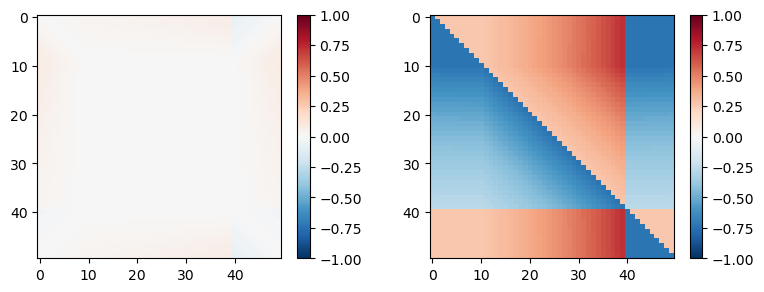

(50, 50, 1, 1)


In [88]:
function get_data(G)
    nt = length(G.grid)
    norb = norbitals(G)
    data = zeros(ComplexF64,(nt, nt, norb, norb))
    for i in G.grid, j in G.grid
        data[i.idx, j.idx, :, :] .= G[i, j]
    end
    data
end

function test()
    tmax = 1.0
    β = 10.0
    nt = 10
    ntau = 30
  
    c = twist(FullContour(; tmax, β))
    grid = FullTimeGrid(c, nt, ntau)

    dos = kd.SingularDOS(1, -1, x -> 0, [kd.DOSSingularity(0.1, x -> 0, 1)])
    g = GenericTimeGF(dos, grid)

    data = get_data(g)
    println(size(data))
    data
end

data = test();
plot2d(data[:, :, 1, 1])

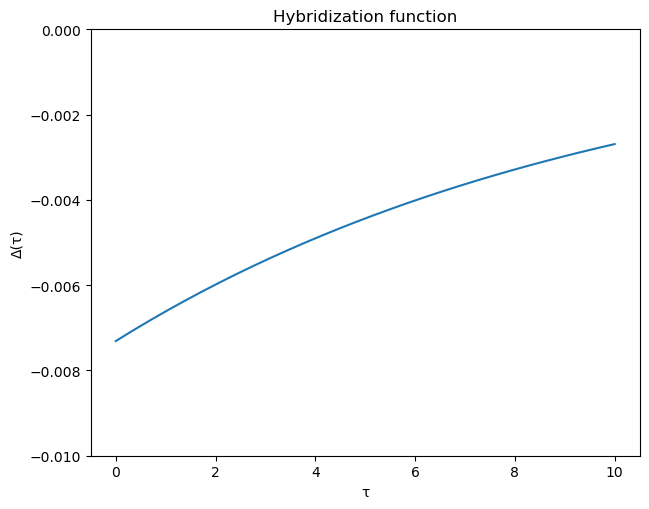

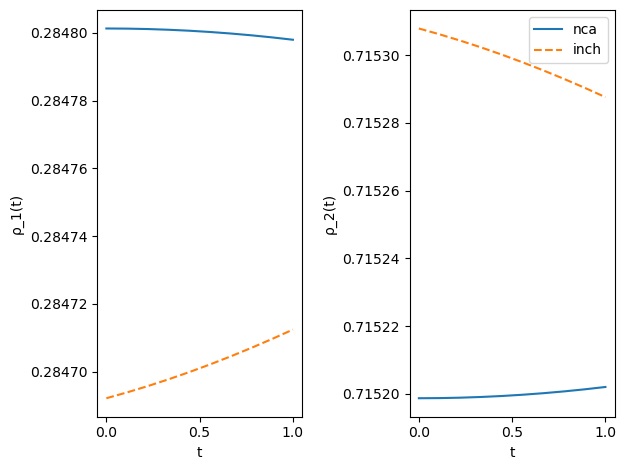

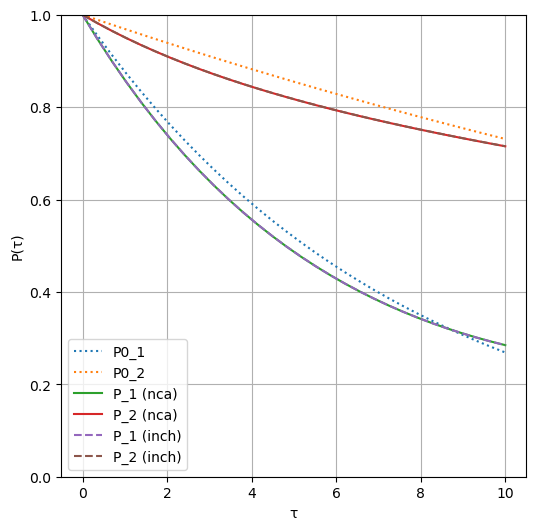

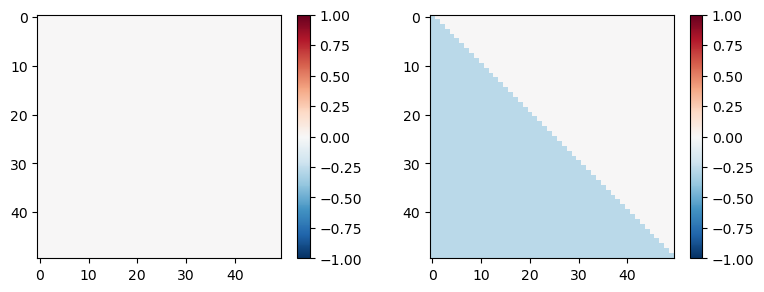

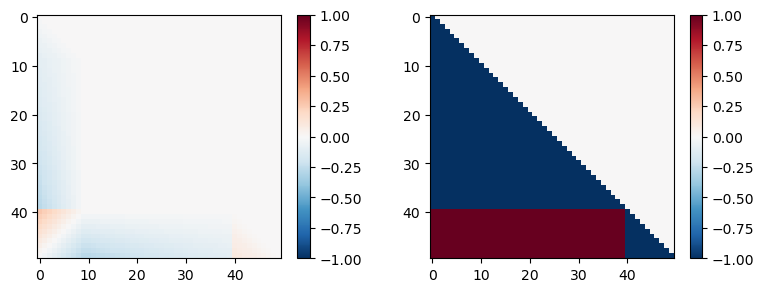

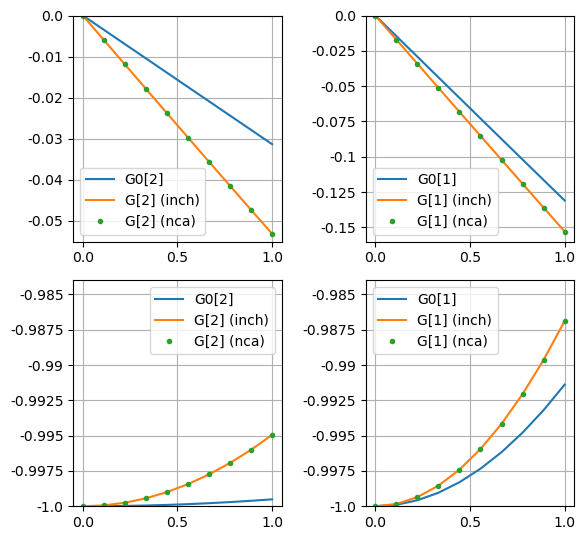

3.7182818284590464 + 0.0im
4.647925424526909 + 0.0im
4.645496264612108 + 0.0im


No handles with labels found to put in legend.


In [132]:
import Keldysh; kd = Keldysh



function run_inch_full()
  tmax = 1.0
  β = 10.0
  nt = 10
  ntau = 30
  
  c = twist(FullContour(; tmax, β))
  grid = FullTimeGrid(c, nt, ntau)

  t = collect(realtimes(grid))
  τ = collect(imagtimes(grid))
    
  ε = 0.1
  V = -0.1
  μ = 0.1
  U = 0.0

  P0 = make_bare_prop(grid, -μ, U)
  
  #dos = flat_dos(;D=10.0, ν=10.0)
  #Δ = [GenericTimeGF(dos, grid) for s in 1:2]
  dos = kd.SingularDOS(1, -1, x -> 0, [kd.DOSSingularity(ε, x -> 0, V^2)])
  Δ = [GenericTimeGF(dos, grid)]
  
  plt.figure()
  fig, ax = plt.subplots(ncols=1)
  ax.plot(τ, real(Δ[1][:matsubara]))
  plt.tight_layout()
  plt.ylabel("Δ(τ)")
  plt.xlabel("τ")
  plt.title("Hybridization function")
  plt.ylim([-0.01, 0.0])
        
  nca_params = NCAParams(max_order = 1)
  nca_data = NCAData(P0, Δ)
  nca!(nca_data, nca_params)
  
  inch_params = InchParams(max_order = 1)
  inch_data = InchData(P0, Δ)
  inch!(inch_data, inch_params)
    
  ρt_0, Zt_0 = populations(P0)
  ρt_nca, Zt_nca = populations(nca_data.P)
  ρt_inch, Zt_inch = populations(inch_data.P)
  
  #fig, axes = plt.subplots(ncols=2, sharey=true)
  plt.figure()
  fig, axes = plt.subplots(ncols=2)
  #for s in 1:4
  for s in 1:2
    axes[s].plot(t, real(ρt_nca[:,s]), label="nca")
    axes[s].plot(t, real(ρt_inch[:,s]), "--", label="inch")
    axes[s].set_ylabel("ρ_$s(t)")
    axes[s].set_xlabel("t")
    plt.legend(loc="best")
  end

    
  plt.tight_layout()
    
  plt.figure(figsize=(6, 6))
  #fig, ax = plt.subplots(ncols=1)
  ax = plt.subplot()

  λ_0 = log(Zt_0[1, 1]) / β
  λ_nca = log(Zt_nca[1, 1]) / β
  λ_inch = log(Zt_inch[1, 1]) / β

  println(Zt_0[1, 1])
  println(Zt_nca[1, 1])
  println(Zt_inch[1, 1])
    
  for s in 1:2
    ax.plot(τ, -real(P0[s][:matsubara]) .* exp.(-τ * λ_0), ":", label="P0_$s")
  end
  for s in 1:2
    ax.plot(τ, -real(nca_data.P[s][:matsubara]) .* exp.(-τ * λ_nca), label="P_$s (nca)")
  end
  for s in 1:2
    ax.plot(τ, -real(inch_data.P[s][:matsubara])  .* exp.(-τ * λ_inch), "--", label="P_$s (inch)")
  end

  plt.ylabel("P(τ)")
  plt.xlabel("τ")
  plt.ylim([0, 1])
  plt.grid(true)
  plt.legend(loc="best")
  #plt.tight_layout()
    
  plt.figure()
  plot2d(get_data(P0[1])[:, :, 1, 1] / Zt_0[1, 1])

  plt.figure()
  plot2d(get_data(P0[2])[:, :, 1, 1])
  
  fi = grid[kd.forward_branch][1].idx
  ff = grid[kd.forward_branch][end].idx
  
ylim = [-1, -0.984]

plt.figure(figsize=(6, 5.5))

ϕ_0 = exp.(-1im .* λ_0 .* t)
ϕ_nca = exp.(-1im .* λ_nca .* t)
ϕ_inch = exp.(-1im .* λ_inch .* t)
    
plt.subplot(2, 2, 1)
#plt.plot(t, real(ϕ_0 .* -im .* exp.(1im * 0 * t)), "-", label="-i * exp(i * E_1 * t)");
plt.plot(t, real(ϕ_0 .* get_data(P0[2])[fi:ff, fi, 1, 1]), "-", label="G0[2]");
plt.plot(t, real(ϕ_inch .* get_data(inch_data.P[2])[fi:ff, fi, 1, 1]), "-", label="G[2] (inch)");
plt.plot(t, real(ϕ_nca .* get_data(nca_data.P[2])[fi:ff, fi, 1, 1]), ".", label="G[2] (nca)");
plt.legend();
plt.grid(true);
tick = -0.05:0.01:0.0
plt.yticks(tick, tick)
plt.ylim([-0.055, 0]);

plt.subplot(2, 2, 2)
#plt.plot(t, real(ϕ_0 .* -im .* exp.(1im * ε * t)), "-", label="-i * exp(i * E_2 * t)");
plt.plot(t, real(ϕ_0 .* get_data(P0[1])[fi:ff, fi, 1, 1]), "-", label="G0[1]");
plt.plot(t, real(ϕ_inch .* get_data(inch_data.P[1])[fi:ff, fi, 1, 1]), "-", label="G[1] (inch)");
plt.plot(t, real(ϕ_nca .* get_data(nca_data.P[1])[fi:ff, fi, 1, 1]), ".", label="G[1] (nca)");
plt.legend();
plt.grid(true);
tick = -0.15:0.025:0.0
plt.yticks(tick, tick)
plt.ylim([-0.16, 0]);

plt.subplot(2, 2, 3)
#plt.plot(t, imag(ϕ_0 .* -im .* exp.(1im * 0 * t)), "-", label="-i * exp(i * E_1 * t)");
plt.plot(t, imag(ϕ_0 .* get_data(P0[2])[fi:ff, fi, 1, 1]), "-", label="G0[2]");
plt.plot(t, imag(ϕ_inch .* get_data(inch_data.P[2])[fi:ff, fi, 1, 1]), "-", label="G[2] (inch)");
plt.plot(t, imag(ϕ_nca .* get_data(nca_data.P[2])[fi:ff, fi, 1, 1]), ".", label="G[2] (nca)");
#plt.plot(t, imag(G[1][1, 1, fi:ff, fi]), ".-", label="G[1]");
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);

plt.subplot(2, 2, 4)
#plt.plot(t, imag(ϕ_0 .* -im .* exp.(1im * ε * t)), "-", label="-i * exp(i * E_2 * t)");
plt.plot(t, imag(ϕ_0 .* get_data(P0[1])[fi:ff, fi, 1, 1]), "-", label="G0[1]");
plt.plot(t, imag(ϕ_inch .* get_data(inch_data.P[1])[fi:ff, fi, 1, 1]), "-", label="G[1] (inch)");
plt.plot(t, imag(ϕ_nca .* get_data(nca_data.P[1])[fi:ff, fi, 1, 1]), ".", label="G[1] (nca)");
#plt.plot(t, imag(G[2][1, 1, 1:idx, 1]), ".-", label="G[2]");
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);    

plt.tight_layout();
    
end

run_inch_full();